Using device: cpu
Epoch 0, PDE loss = 5.3551e-03, BC loss = 4.5061e-03
Epoch 500, PDE loss = 1.1338e-06, BC loss = 2.7922e-07
Epoch 1000, PDE loss = 3.6672e-07, BC loss = 1.9265e-07
Epoch 1500, PDE loss = 1.1404e-07, BC loss = 9.0022e-08
Epoch 2000, PDE loss = 5.1068e-08, BC loss = 4.7681e-08
Epoch 2500, PDE loss = 3.4566e-08, BC loss = 3.0636e-08
Epoch 3000, PDE loss = 2.6470e-08, BC loss = 2.0809e-08
Epoch 3500, PDE loss = 4.4713e-06, BC loss = 1.6783e-05
Epoch 4000, PDE loss = 1.7538e-08, BC loss = 1.6740e-08
Epoch 4500, PDE loss = 1.3568e-08, BC loss = 8.0320e-09
Training complete. The solution should be ~0 inside the domain.


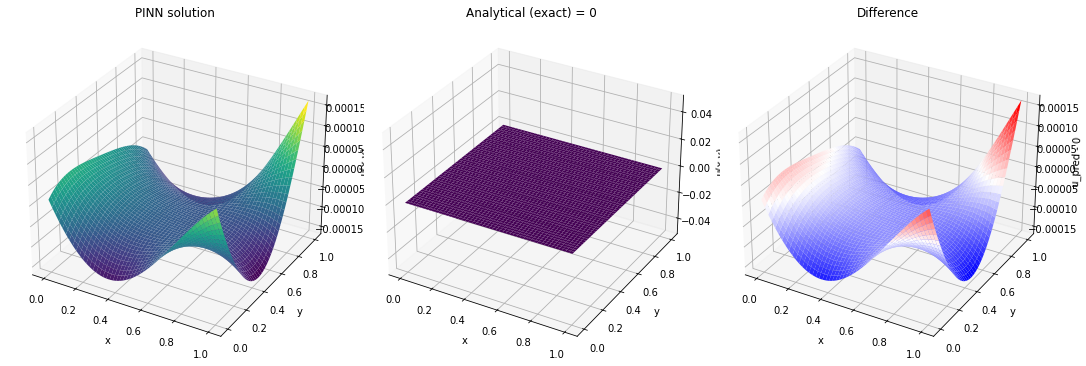

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title: 2D Laplace Equation with Zero BCs using PINNs

We solve:
    u_xx + u_yy = 0,   (x,y) in (0,1)x(0,1)
with boundary conditions:
    u=0  on all boundary edges (x=0, x=1, y=0, y=1).

Trivial analytical solution: u(x,y) = 0.

PINN approach:
    - A neural network u_theta(x,y).
    - PDE residual: u_xx + u_yy.
    - BC: enforce u=0 at boundary.

After training, we plot the PINN's 3D solution, the analytical
(zero) solution, and their difference.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # (optional, in newer matplotlib it's built-in)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class LaplaceNet(nn.Module):
    """
    Neural network that takes (x,y) as input and outputs scalar u(x,y).
    We'll use a few hidden layers with Tanh activation.
    """
    def __init__(self, hidden_units=20):
        super(LaplaceNet, self).__init__()
        self.layer1 = nn.Linear(2, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, xy):
        # xy has shape (N,2): columns [x, y]
        out = self.activation(self.layer1(xy))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

def laplace_residual(model, x, y):
    """
    Compute the residual for Laplace's eq: u_xx + u_yy = 0.
    """
    # x,y need gradients
    x.requires_grad_(True)
    y.requires_grad_(True)

    # Construct input
    inp = torch.cat([x, y], dim=1)  # shape (N,2)
    u = model(inp)                  # shape (N,1)

    # First partial derivatives
    dudx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]
    dudy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                               create_graph=True)[0]

    # Second partial derivatives
    d2udx2 = torch.autograd.grad(dudx, x, grad_outputs=torch.ones_like(dudx),
                                 create_graph=True)[0]
    d2udy2 = torch.autograd.grad(dudy, y, grad_outputs=torch.ones_like(dudy),
                                 create_graph=True)[0]

    # Laplace PDE residual = u_xx + u_yy
    res = d2udx2 + d2udy2
    return res

def boundary_sampler(N):
    """
    Sample points on the boundary of the unit square [0,1]^2:
       x=0, x=1, y=0, y=1
    We'll combine them into a single tensor.

    Returns: (4N, 2) tensor
    """
    # For top (y=1) and bottom (y=0), we vary x in [0,1]
    x_h = torch.rand((N,1), device=device)
    top = torch.cat([x_h, torch.ones_like(x_h)], dim=1)      # y=1
    bottom = torch.cat([x_h, torch.zeros_like(x_h)], dim=1)  # y=0

    # For left (x=0) and right (x=1), we vary y in [0,1]
    y_v = torch.rand((N,1), device=device)
    left = torch.cat([torch.zeros_like(y_v), y_v], dim=1)    # x=0
    right = torch.cat([torch.ones_like(y_v), y_v], dim=1)    # x=1

    # Combine
    boundary = torch.cat([top, bottom, left, right], dim=0)  # shape (4N,2)
    return boundary

def main():
    # Instantiate the model
    model = LaplaceNet(hidden_units=30).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5000

    # Interior collocation points
    N_interior = 2000
    xy_interior = torch.rand((N_interior, 2), device=device)
    x_in = xy_interior[:,0:1]
    y_in = xy_interior[:,1:2]

    # Boundary points
    boundary_xy = boundary_sampler(200)  # 200 points per edge => 800 total

    # -------------- Training Loop --------------
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1) PDE residual inside domain
        res = laplace_residual(model, x_in, y_in)
        loss_pde = torch.mean(res**2)

        # 2) Boundary condition: u=0 at boundary
        u_bdry = model(boundary_xy)
        loss_bc = torch.mean(u_bdry**2)

        # 3) Total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, PDE loss = {loss_pde.item():.4e}, BC loss = {loss_bc.item():.4e}")

    print("Training complete. The solution should be ~0 inside the domain.")

    # -------------- 3D Plotting --------------
    # Evaluate the solution on a regular grid
    Nx, Ny = 50, 50
    x_space = torch.linspace(0, 1, Nx, device=device)
    y_space = torch.linspace(0, 1, Ny, device=device)
    # meshgrid (indexing='xy'): X.shape= (Ny, Nx), Y.shape=(Ny, Nx)
    X, Y = torch.meshgrid(x_space, y_space, indexing='xy')
    # Flatten for model input => (Nx*Ny,2)
    XY_flat = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], dim=1)
    # Predict
    u_pred = model(XY_flat).detach().cpu().numpy()
    # Reshape to 2D
    U_pred = u_pred.reshape(Nx, Ny).T  # shape (Ny, Nx)

    # Analytical (exact) solution is 0 => U_true = 0 array
    U_true = np.zeros((Ny, Nx))
    U_diff = U_pred - U_true

    # Convert X,Y to numpy for plotting, matching shape with U_pred
    X_np = X.cpu().numpy()
    Y_np = Y.cpu().numpy()

    # For 3D plotting, we typically want arrays of shape (Ny, Nx)
    # Right now, X_np.shape= (Nx,Ny), same with Y_np => must transpose one
    # But let's be consistent with how we shaped U_pred. We used U_pred= shape(Ny,Nx).
    # So let's define Xp, Yp for plotting, each shape (Ny,Nx).
    Xp = X_np.T  # shape (Ny,Nx)
    Yp = Y_np.T  # shape (Ny,Nx)

    # Now we'll plot 3D surfaces: PINN solution, Analytical (zero), and difference
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(15, 5))

    # --- Subplot 1: PINN solution ---
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(Xp, Yp, U_pred, cmap='viridis')
    ax1.set_title("PINN solution")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("u(x,y)")

    # --- Subplot 2: Analytical solution (0) ---
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(Xp, Yp, U_true, cmap='viridis')
    ax2.set_title("Analytical (exact) = 0")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")

    # --- Subplot 3: Difference (PINN - Exact) ---
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.plot_surface(Xp, Yp, U_diff, cmap='bwr')
    ax3.set_title("Difference")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_zlabel("u_pred - 0")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
